# **Pairs Trading**

Pairs Trading is a market-neutral trading strategy which involves matching a long position with a short position in two securities which have a high level of positive correlation. It is a form of **statistical arbitrage** i.e it looks at the relative price movement between the two securities.

As it is a market-neutral strategy, it is independent of the trend being followed by the overall market (upwards or downwards). Instead, pairs trading works on the concept of mean-reversion. When two highly correlated securites deviate from their general trend, it is expected that they will return back to that trend in the future.

The spread between the stock prices created during the deviation serves as an opportunity for profit. One can open a long position on the stock expected to move upwards and a short position on the stock expected to move downwards. If the pair performs as expected, it is a profitable trade.

Even if the pair does not perform as expected, the trader will be able to mitigate some portion of their losses as the loss on one security will be offset by the profits on the other security. Hence, pairs trading also acts as a form of hedging and can be used to minimise losses.

## **Importing Libraries**

In [48]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


In [49]:
pip install pandas_ta

Defaulting to user installation because normal site-packages is not writeable


In [50]:
pip install backtesting bokeh


Defaulting to user installation because normal site-packages is not writeable


In [51]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from statsmodels.tsa.stattools import coint, adfuller
import pandas_ta as ta
import statsmodels
import statsmodels.api as sm
import backtesting
from backtesting import Backtest
from backtesting.lib import crossover
import bokeh

## **Importing Stock Price dataset**

For the purpose of this strategy, a lookback period of four years from 2018-2022 will be used to identify stock pairs having high positive correlation. In particular, stocks from the banking sector will be considered and hence the stocks of the BANK NIFTY index have been taken.


In [52]:
start_date = "2018-12-31"
end_date = "2022-12-31"

stocks = ["INDUSINDBK.NS", "HDFCBANK.NS", "PNB.NS", "ICICIBANK.NS", "BANKBARODA.NS", "SBIN.NS", "IDFCFIRSTB.NS", "KOTAKBANK.NS", "FEDERALBNK.NS", "AXISBANK.NS", "AUBANK.NS"]

In [53]:
stock_data =  yf.download(stocks, start = start_date ,end= end_date)['Adj Close']
stock_data.head()

[                       0%%                      ]

[*********************100%%**********************]  11 of 11 completed


Ticker,AUBANK.NS,AXISBANK.NS,BANKBARODA.NS,FEDERALBNK.NS,HDFCBANK.NS,ICICIBANK.NS,IDFCFIRSTB.NS,INDUSINDBK.NS,KOTAKBANK.NS,PNB.NS,SBIN.NS
Date,,,,,,,,,,,
2018-12-31,310.026154,617.559937,111.988968,89.028763,1009.855225,353.179352,43.349998,1553.385498,1253.412354,75.445885,283.184784
2019-01-01,309.951416,624.931946,116.230972,88.790077,1022.420898,356.709686,43.349998,1549.791748,1247.377319,77.088120,286.725800
2019-01-02,309.104218,617.709351,112.507431,90.508591,1013.091858,357.543213,42.700001,1531.337158,1237.551636,75.204376,281.270721
2019-01-03,309.652374,605.654968,112.460297,87.835350,1005.143127,356.219330,43.049999,1515.310913,1232.214600,75.204376,278.591064
2019-01-04,310.898254,617.260986,114.722694,90.508591,1007.832397,358.131653,45.150002,1503.752441,1244.883545,78.537140,284.859558


Let's plot some stock prices!

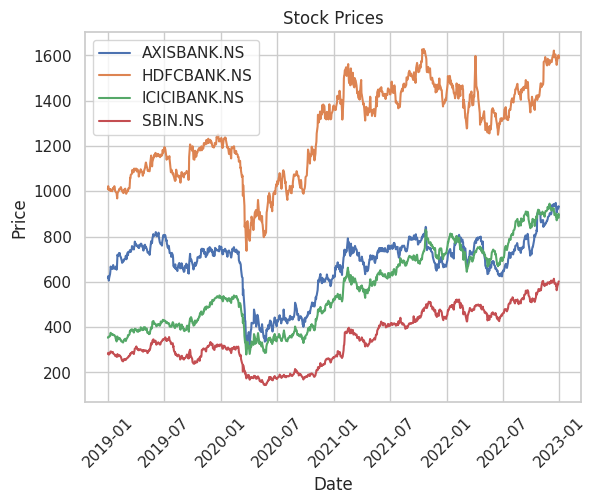

In [54]:
plt.plot(stock_data[['AXISBANK.NS','HDFCBANK.NS','ICICIBANK.NS','SBIN.NS']])
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Prices")
plt.legend(['AXISBANK.NS','HDFCBANK.NS','ICICIBANK.NS','SBIN.NS'])


## **Identifying stock pairs**

### **Cointegration**

Cointegration is a statistical method which is used to identify the correlation between two non-stationary time series in the long run or over a specified period.

**Finding stock pairs with cointegrated time series:**

In [55]:
def cointegration_test(stock_data, stocks):
    N = stock_data.shape[1]
    pvalues = np.ones((N, N))
    stock_pairs = []

    for i in range(N):
      for j in range(N):
        if i == j:
          continue

        result = coint(stock_data[stocks[i]], stock_data[stocks[j]])
        pval = result[1]
        pvalues[i][j] = pval

        if(pval < 0.05 and stocks[i] != stocks[j]):                   # Cutoff threshold for 95% confidence
          stock_pairs.append((pval, (stocks[i], stocks[j])))

    return pvalues, stock_pairs

<Axes: >

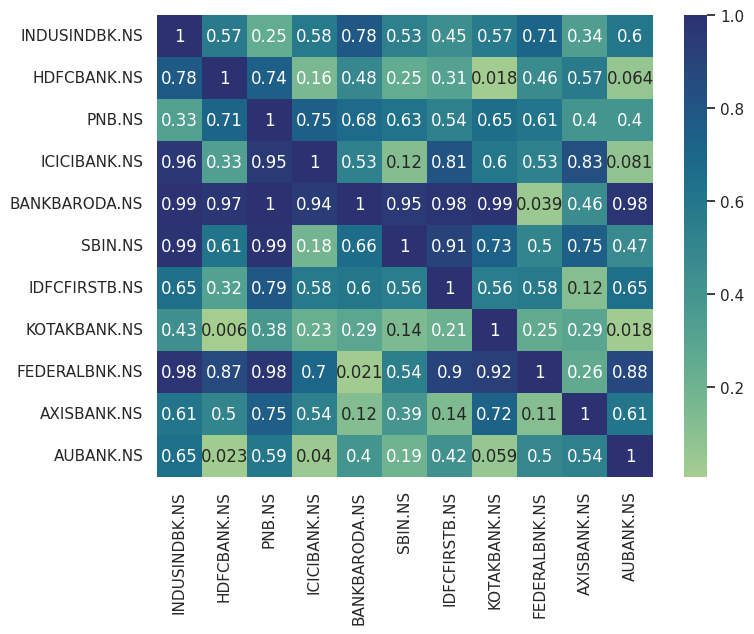

In [56]:
pvalues, stock_pairs = cointegration_test(stock_data, stocks)
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
sns.heatmap(pvalues, xticklabels = stocks, yticklabels = stocks, cmap = 'crest',  annot = True)

The pairs of stocks having a cointegration are those with a p-value less than the threshold of 0.05.
P-value can be considered as a measure of the strength of cointegration between the two series. A lower p-value indicates a stronger cointegration

In [57]:
min(stock_pairs)

(0.006010523314895846, ('KOTAKBANK.NS', 'HDFCBANK.NS'))

**Selected pair: HDFC Bank & Kotak Bank**

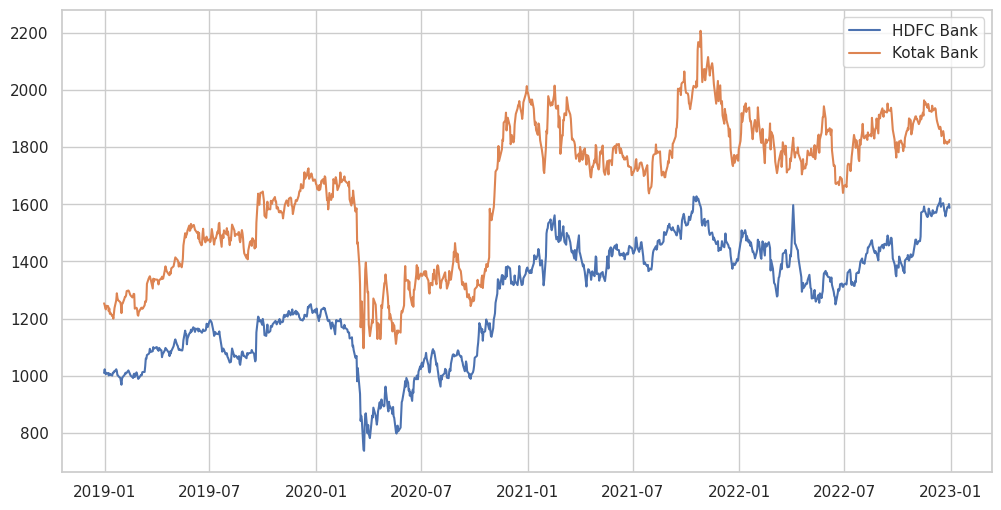

In [58]:
plt.figure(figsize = (12, 6))
plt.plot(stock_data['HDFCBANK.NS'], label = 'HDFC Bank')
plt.plot(stock_data['KOTAKBANK.NS'], label = 'Kotak Bank')
plt.legend()
plt.show()

Text(0, 0.5, 'HDFC Bank')

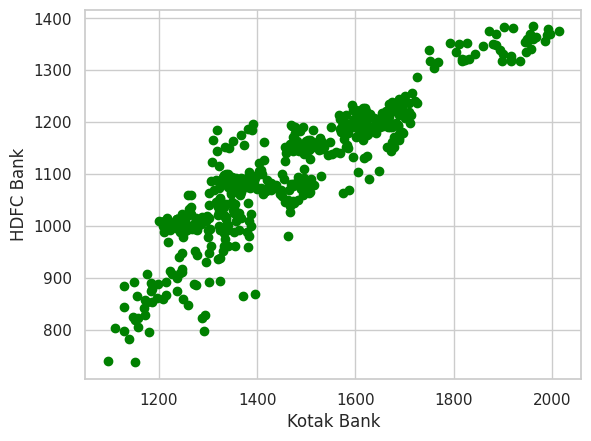

In [59]:
plt.scatter(stock_data['KOTAKBANK.NS'].head(500),stock_data['HDFCBANK.NS'].head(500),c="green")
plt.xlabel("Kotak Bank")
plt.ylabel("HDFC Bank")

### **Testing Data**

The strategy will use a 6 month testing period from January 2023 to June 2023. The spread between the prices of the two stocks will be used to determine points of entry and exit for the pairs trade.

[                       0%%                      ]

[*********************100%%**********************]  2 of 2 completed


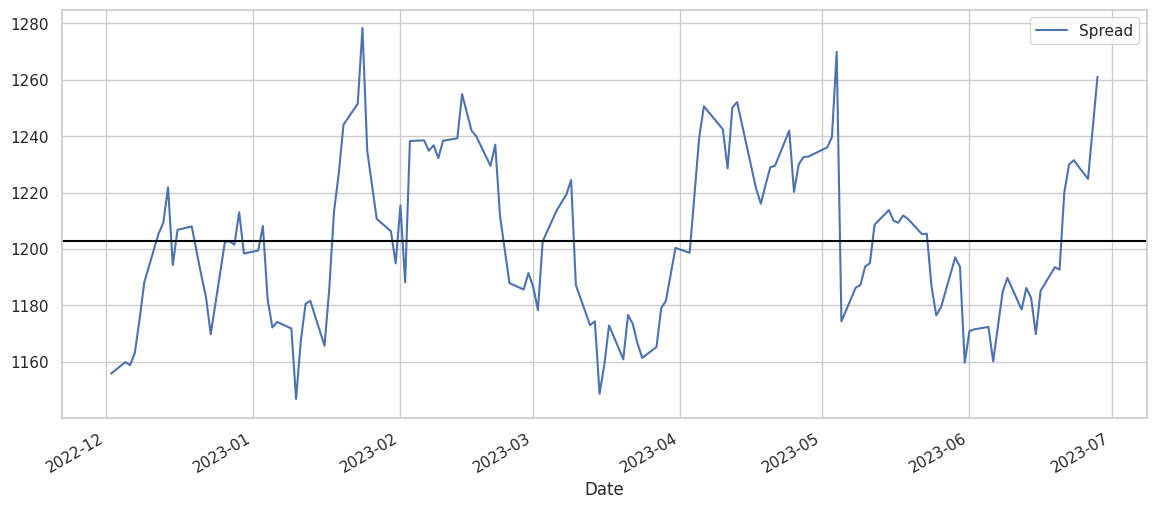

In [60]:
stock_pair = ['KOTAKBANK.NS', 'HDFCBANK.NS']
asset_pairs =  yf.download(stock_pair, start="2022-12-02" ,end= "2023-06-30")['Adj Close']

S1=asset_pairs[stock_pair[0]]
S2=asset_pairs[stock_pair[1]]

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1[stock_pair[0]]
b = results.params[stock_pair[0]]

spread = S2 - b * S1
spread.plot(figsize=(14, 6))
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

## **Z-Score**

A Z-score is a numerical measurement that describes a value's relationship to the mean of a group of values. Z-score is measured in terms of standard deviations from the mean. Z-scores also make it possible to adapt values from data sets having a very different ranges to make scores that are comparable.
Essentially, z-scores can shrink a large range of values into a much smaller range which is easier to handle.

Zscore.svg

𝒳 = series

μ = series mean

σ = series standard deviation

In [61]:
def zscore(series):
    lookback = 20
    scores = []
    for i in range(lookback, len(series)):
      window = series[i-lookback:i]
      scores.append((series[i]-window.mean())/window.std())
    return pd.Series(scores, index = series.index[lookback:])


/tmp/ipykernel_11317/2471693185.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scores.append((series[i]-window.mean())/window.std())


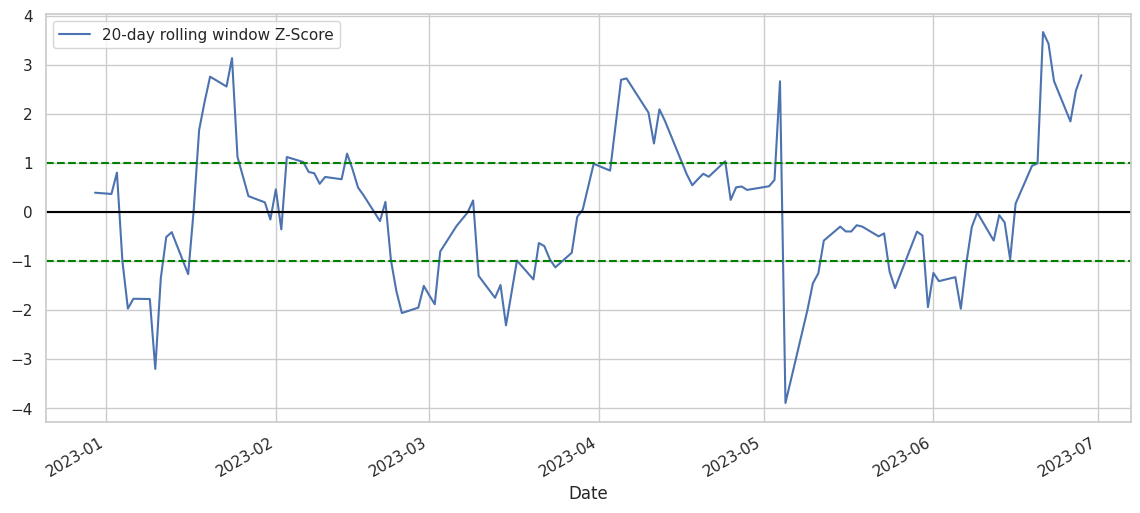

In [62]:
zscore(spread).plot(figsize=(14, 6))
plt.axhline(0.0, color='black')
plt.axhline(1.0, color='green', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['20-day rolling window Z-Score'])

## **Trading Strategy**

Implementation of a simple mean-reversion based strategy. The threshold levels for the Z-score are taken as +1 and -1. Whenever the Z-score value rises above +1, it is expected to fall in the future and a short position is taken on the pair. Similarly, when the Z-score value falls below -1, it is expected to rise in the future and a long position is taken on the pair.


In [63]:
def generate_trade_signals(S1, S2, spread):
  signals = pd.DataFrame()
  signals['price1'] = S1
  signals['price2'] = S2
  signals['spread'] = spread
  signals['zscore'] = zscore(spread)

  signals.dropna(inplace = True)

  signals['signal1'] = np.select([signals['zscore'] > 1, signals['zscore'] < -1], [1, -1], default = 0)
  signals['position1'] = signals['signal1'].diff()
  signals['signal2'] = -signals['signal1']
  signals['position2'] = signals['signal2'].diff()

  return signals

In [64]:
trade_signals = generate_trade_signals(S1, S2, spread)
trade_signals.dropna(inplace = True)
trade_signals

/tmp/ipykernel_11317/2471693185.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scores.append((series[i]-window.mean())/window.std())


,price1,price2,spread,zscore,signal1,position1,signal2,position2
Date,,,,,,,,
2023-01-02,1823.548584,1588.541748,1199.387971,0.367378,0,0.0,0,0.0
2023-01-03,1831.342041,1598.929077,1208.112140,0.801864,0,0.0,0,0.0
2023-01-04,1819.252075,1570.351685,1182.114803,-1.000309,-1,-1.0,1,1.0
2023-01-05,1818.802490,1560.256714,1172.115775,-1.968815,-1,0.0,1,0.0
2023-01-06,1785.329956,1555.087524,1174.089781,-1.768813,-1,0.0,1,0.0
...,...,...,...,...,...,...,...,...
2023-06-22,1834.589355,1621.458252,1229.948323,3.429538,1,0.0,-1,0.0
2023-06-23,1827.045654,1621.359619,1231.459551,2.668262,1,0.0,-1,0.0
2023-06-26,1821.450195,1613.516724,1224.810752,1.845992,1,0.0,-1,0.0


### **Visualising the positions**

**1) Trades on the pair**

In [65]:
def plot_pair_trades(trade_signals):
  fig = plt.figure(figsize=(14, 6))
  bx = fig.add_subplot(111)
  series = bx.plot(trade_signals['zscore'], c='#4abdac')
  long = bx.plot(trade_signals['zscore'][trade_signals['position1'] == -1], lw = 0, marker = '^', markersize = 8, c = 'g', alpha = 0.9)
  short = bx.plot(trade_signals['zscore'][trade_signals['position1'] == 1], lw = 0, marker = 'v', markersize = 8, c = 'r', alpha = 0.9)
  stock1 = stock_pair[0]
  stock2 = stock_pair[1]
  plt.title(f'{stock2} / {stock1}')
  plt.legend(['Z-Score', 'Long', 'Short'])

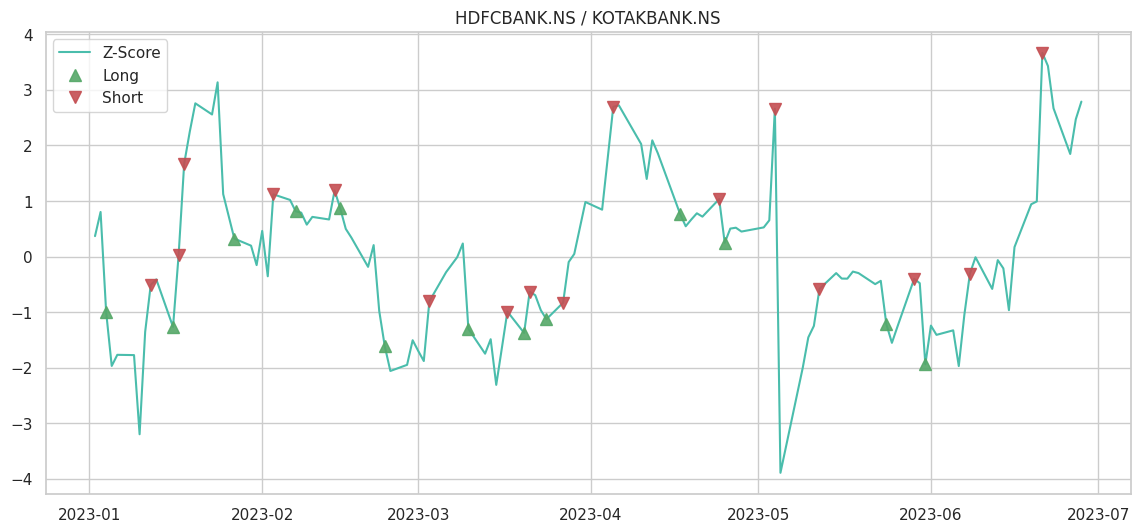

In [66]:
plot_pair_trades(trade_signals)

*   **Long position => buy HDFC Bank and sell Kotak Bank**
*   **Short position => sell HDFC Bank and buy Kotak Bank**

**2) Trades on Kotak Bank**

In [67]:
def plot_trades_1(signals):
  fig = plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price1'], c='#4abdac')
  u1 = bx.plot(signals['price1'][signals['position1'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2, = bx.plot(signals['price1'][signals['position1'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[0])
  plt.legend(['Price', 'Long', 'Short'])

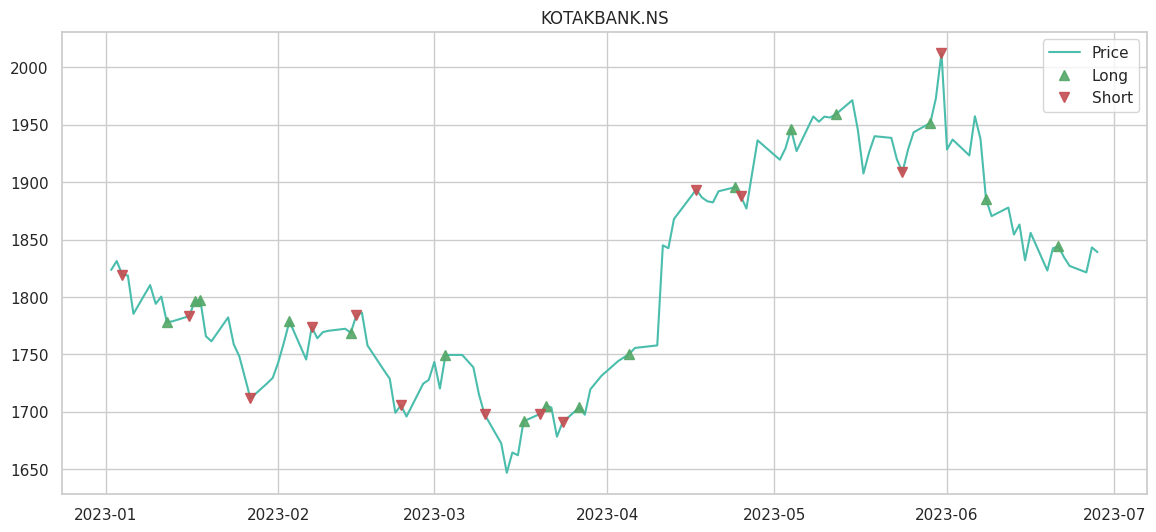

In [68]:
plot_trades_1(trade_signals)

**3) Trades on HDFC Bank**

In [69]:
def plot_trades_2(signals):
  fig=plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price2'], c='#4abdac')
  u1 = bx.plot(signals['price2'][signals['position2'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2 = bx.plot(signals['price2'][signals['position2'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[1])
  plt.legend(['Price', 'Long', 'Short'])

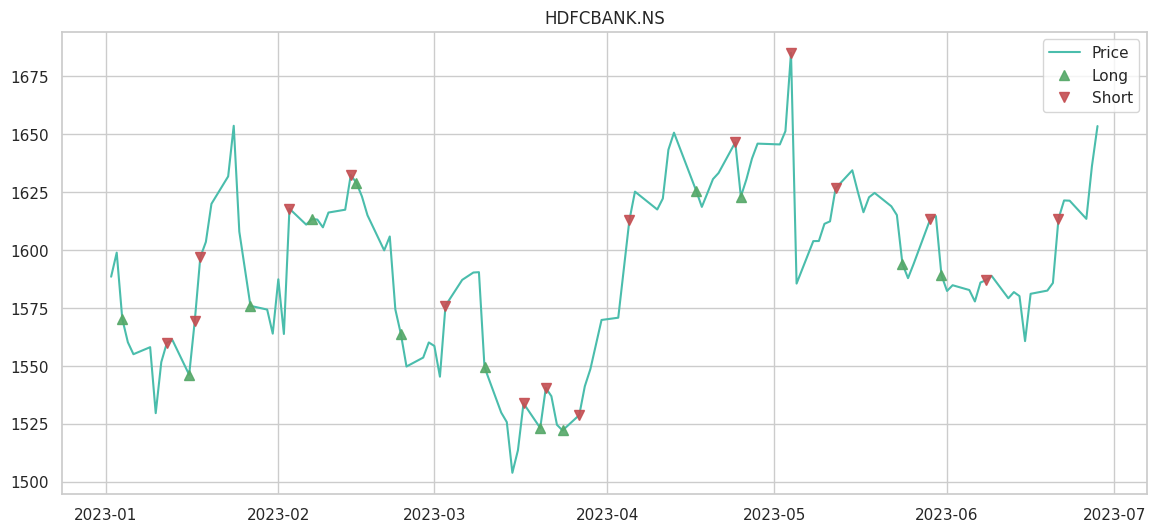

In [70]:
plot_trades_2(trade_signals)

## **Portfolio Performance**

### **PnL Calculation**

In [71]:
def pnl_calculation(signals):

  initial_capital = 50000

  # Shares to buy for each stock
  shares1 = initial_capital// (signals['price1'][0])
  shares2 = initial_capital// (signals['price2'][0])

  #PnL for stock 1
  portfolio = pd.DataFrame()
  portfolio['holdings1'] = signals['position1'].cumsum() * signals['price1'] * shares1
  portfolio['cash1'] = initial_capital - (signals['position1'] * signals['price1'] * shares1).cumsum()
  portfolio['total1'] = portfolio['holdings1'] + portfolio['cash1']
  portfolio['return1'] = portfolio['total1'].pct_change()

  # PnL for stock 2
  portfolio['holdings2'] = signals['position2'].cumsum() * signals['price2'] * shares2
  portfolio['cash2'] = initial_capital - (signals['position2'] * signals['price2'] * shares2).cumsum()
  portfolio['total2'] = portfolio['holdings2'] + portfolio['cash2']
  portfolio['return2'] = portfolio['total2'].pct_change()

  # Total PnL
  portfolio['total'] = portfolio['total1'] + portfolio['total2']
  portfolio = portfolio.dropna()

  return portfolio


In [72]:
portfolio = pnl_calculation(trade_signals)
portfolio.head()

/tmp/ipykernel_11317/791995448.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shares1 = initial_capital// (signals['price1'][0])
/tmp/ipykernel_11317/791995448.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shares2 = initial_capital// (signals['price2'][0])


,holdings1,cash1,total1,return1,holdings2,cash2,total2,return2,total
Date,,,,,,,,,
2023-01-03,0.000000,50000.00000,50000.000000,0.000000,0.000000,50000.000000,50000.000000,0.000000,100000.000000
2023-01-04,-49119.806030,99119.80603,50000.000000,0.000000,48680.902222,1319.097778,50000.000000,0.000000,100000.000000
2023-01-05,-49107.667236,99119.80603,50012.138794,0.000243,48367.958130,1319.097778,49687.055908,-0.006259,99699.194702
2023-01-06,-48203.908813,99119.80603,50915.897217,0.018071,48207.713257,1319.097778,49526.811035,-0.003225,100442.708252
2023-01-09,-48881.051147,99119.80603,50238.754883,-0.013299,48301.439819,1319.097778,49620.537598,0.001892,99859.292480


In [73]:
def plot_portfolio_value(portfolio):

  fig = plt.figure(figsize=(14,6),)
  ax = fig.add_subplot(111)
  l1, = ax.plot(portfolio['total'], c='g')
  ax.set_ylabel('Asset Value')
  ax.yaxis.labelpad=15
  ax.set_xlabel('Date')
  ax.xaxis.labelpad=15
  plt.title('Portfolio Performance PnL')
  plt.legend(['Total Portfolio Value'])

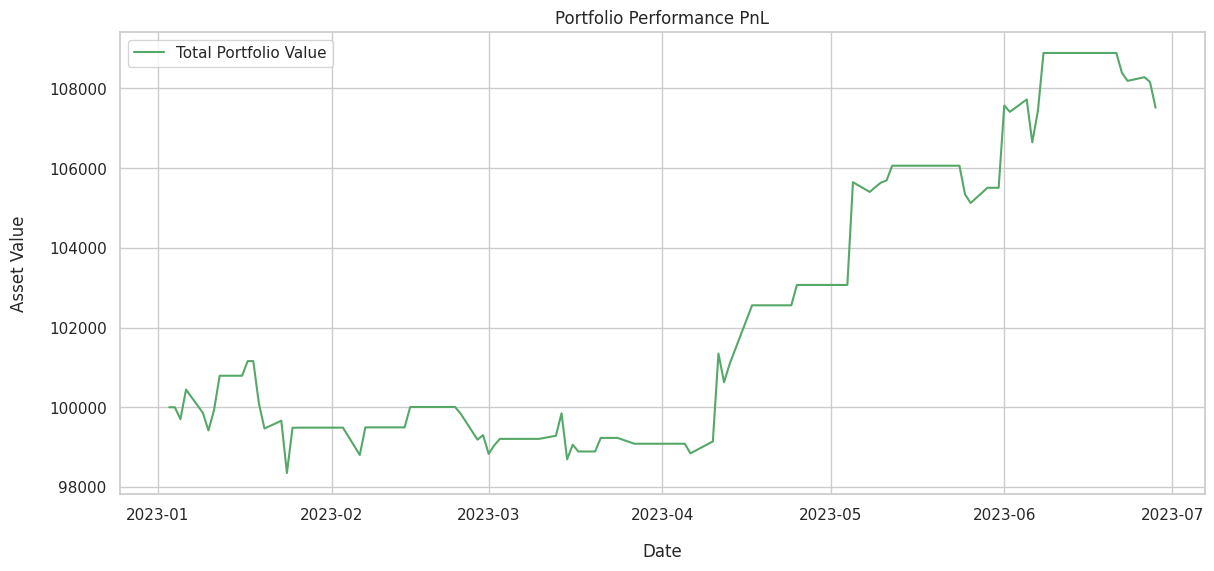

In [74]:
plot_portfolio_value(portfolio)

## **Portfolio Returns**

In [75]:
def calculate_cagr(portfolio):

  final_portfolio = portfolio['total'].iloc[-1]
  initial_portfolio = portfolio['total'].iloc[0]
  delta = len(portfolio.index)
  print('Number of trading days = ', delta)
  YEAR_DAYS = 252
  returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
  return returns

In [76]:
print('CAGR = {:.3f}%' .format(calculate_cagr(portfolio) * 100))

Number of trading days =  120
CAGR = 16.439%


Returns are also compared to a benchmark to assess the performance of the trading strategy in comparison to the overall market. For the purpose of this strategy, the NIFTY BANK index is taken as a benchmark.

[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_11317/1360885660.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shares = 100000/index[0]


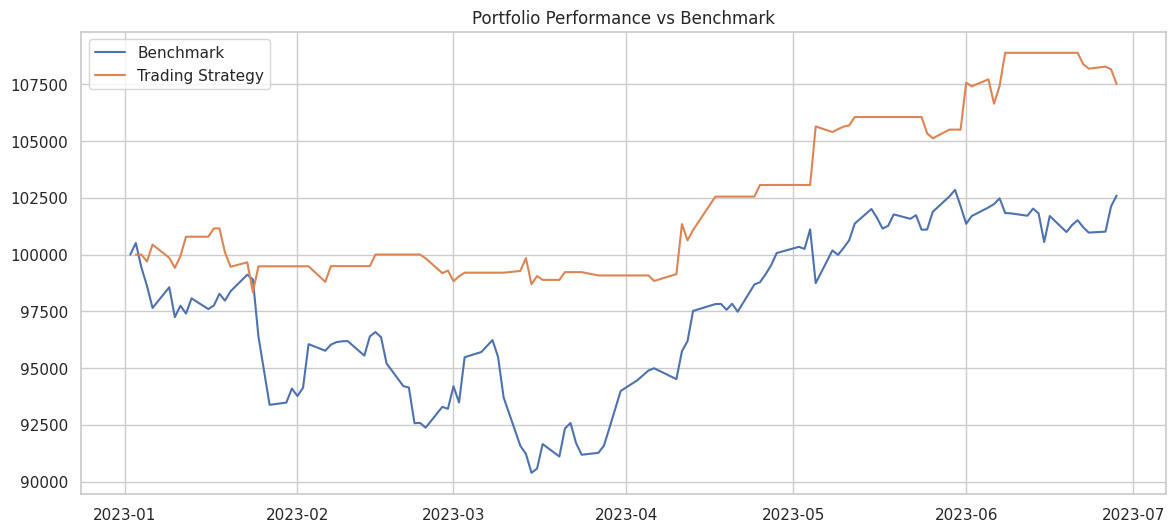

In [77]:
index = yf.download('^NSEBANK', start = '2023-01-01', end = '2023-06-30')['Adj Close']
shares = 100000/index[0]

plt.figure(figsize = (14, 6))
plt.plot(index*shares)
plt.plot(portfolio['total'])
plt.title('Portfolio Performance vs Benchmark')
plt.legend(['Benchmark', 'Trading Strategy'])

In [78]:
cagr_index = (index.iloc[-1] / index[0])**(252/len(index)) - 1
print("CAGR of NIFTY Bank:", np.round(cagr_index*100, 3), "%")
cagr_portfolio = (portfolio['total'][-1] / portfolio['total'][0]) ** (252/len(portfolio)) - 1
print("CAGR of trading strategy:", np.round(cagr_portfolio*100, 3), "%")

CAGR of NIFTY Bank: 5.498 %
CAGR of trading strategy: 16.439 %


/tmp/ipykernel_11317/2059723931.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr_index = (index.iloc[-1] / index[0])**(252/len(index)) - 1
/tmp/ipykernel_11317/2059723931.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr_portfolio = (portfolio['total'][-1] / portfolio['total'][0]) ** (252/len(portfolio)) - 1


Backtesting

In [79]:
dstart="2018-12-02"
dend="2022-12-01"

In [80]:
def calculate_cagr_b(portfolio):

  final_portfolio = portfolio['total'].iloc[-1]
  initial_portfolio = portfolio['total'].iloc[0]
  delta = len(portfolio.index)
  print('Number of trading days = ', delta)
  YEAR_DAYS = 252*4
  returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
  return returns

In [81]:
def backtesting(dstart,dend):
    stock_pair_b = ['KOTAKBANK.NS', 'HDFCBANK.NS']
    asset_pairs_b =  yf.download(stock_pair_b, start=dstart ,end=dend )['Adj Close']

    S1_b=asset_pairs_b[stock_pair_b[0]]
    S2_b=asset_pairs_b[stock_pair_b[1]]

    S1_b = sm.add_constant(S1_b)
    results_b = sm.OLS(S2_b, S1_b).fit()
    S1_b = S1_b[stock_pair_b[0]]
    b_b = results_b.params[stock_pair_b[0]]

    spread_b = S2_b - b_b * S1_b
    spread_b.plot(figsize=(14, 6))
    #print("Spread")
    plt.axhline(spread_b.mean(), color='black')
    plt.legend(['Spread'])
    trade_signals_b = generate_trade_signals(S1_b, S2_b, spread_b)
    trade_signals_b.dropna(inplace = True)
    trade_signals_b
    #print("On pair trade")
    plot_pair_trades(trade_signals_b)
    #print("KOTAKBANK")
    plot_trades_1(trade_signals_b)
    print()
    #print("HDFCBANK")
    plot_trades_2(trade_signals_b)
    print()
    portfolio_b = pnl_calculation(trade_signals_b)
    portfolio_b.head()
    plot_portfolio_value(portfolio_b)
    plot_portfolio_value(portfolio_b)
    print("**CAGR**")
    print('CAGR = {:.3f}%' .format(calculate_cagr_b(portfolio_b) * 100))
    print()
    index_b = yf.download('^NSEBANK', start = dstart, end = dend)['Adj Close']
    shares_b = 100000/index_b[0]

    plt.figure(figsize = (14, 6))
    plt.plot(index_b*shares_b)
    plt.plot(portfolio_b['total'])
    plt.title('Portfolio Performance vs Benchmark')
    plt.legend(['Benchmark', 'Trading Strategy'])
    cagr_index_b = (index_b.iloc[-1] / index_b[0])**((252*4)/len(index_b)) - 1
    print("CAGR of NIFTY vs Trading Strategy")
    print("CAGR of NIFTY Bank:", np.round(cagr_index_b*100, 3), "%")
    cagr_portfolio_b = (portfolio_b['total'][-1] / portfolio_b['total'][0]) ** ((252*4)/len(portfolio_b)) - 1
    print("CAGR of trading strategy:", np.round(cagr_portfolio_b*100, 3), "%")
    print()
    return trade_signals_b

[*********************100%%**********************]  2 of 2 completed
/tmp/ipykernel_11317/2471693185.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scores.append((series[i]-window.mean())/window.std())


/tmp/ipykernel_11317/791995448.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shares1 = initial_capital// (signals['price1'][0])
/tmp/ipykernel_11317/791995448.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shares2 = initial_capital// (signals['price2'][0])
[*********************100%%**********************]  1 of 1 completed



**CAGR**
Number of trading days =  966
CAGR = 32.549%

CAGR of NIFTY vs Trading Strategy
CAGR of NIFTY Bank: 62.925 %
CAGR of trading strategy: 32.549 %




/tmp/ipykernel_11317/899379056.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shares_b = 100000/index_b[0]
/tmp/ipykernel_11317/899379056.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr_index_b = (index_b.iloc[-1] / index_b[0])**((252*4)/len(index_b)) - 1
/tmp/ipykernel_11317/899379056.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr_portfolio_b = (portfolio_b['total'][-1] / portfolio_b['total'][0]) ** ((25

,price1,price2,spread,zscore,signal1,position1,signal2,position2
Date,,,,,,,,
2019-01-02,1237.551514,1013.091797,93.536840,0.317880,0,0.0,0,0.0
2019-01-03,1232.214722,1005.143127,89.553640,0.059590,0,0.0,0,0.0
2019-01-04,1244.883545,1007.832397,82.829420,-0.301937,0,0.0,0,0.0
2019-01-07,1243.536743,1009.355591,85.353346,-0.038618,0,0.0,0,0.0
2019-01-08,1225.880249,1000.954651,90.071954,0.203531,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...
2022-11-24,1943.249878,1585.079224,141.159485,1.198142,1,1.0,-1,-1.0
2022-11-25,1926.813477,1577.764282,146.057509,1.194308,1,0.0,-1,0.0
2022-11-28,1926.563721,1560.793213,129.272019,0.698850,0,-1.0,0,1.0


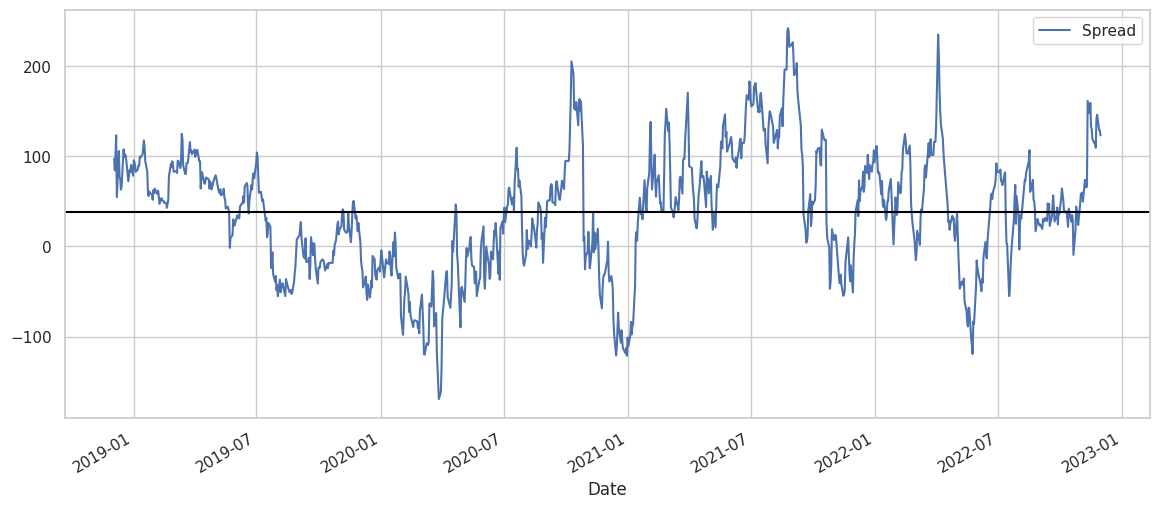

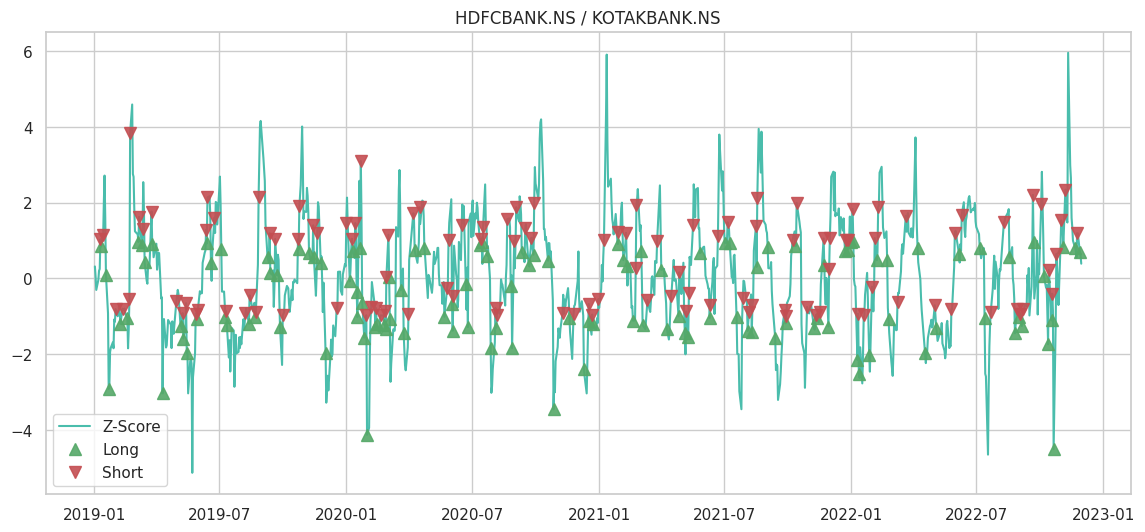

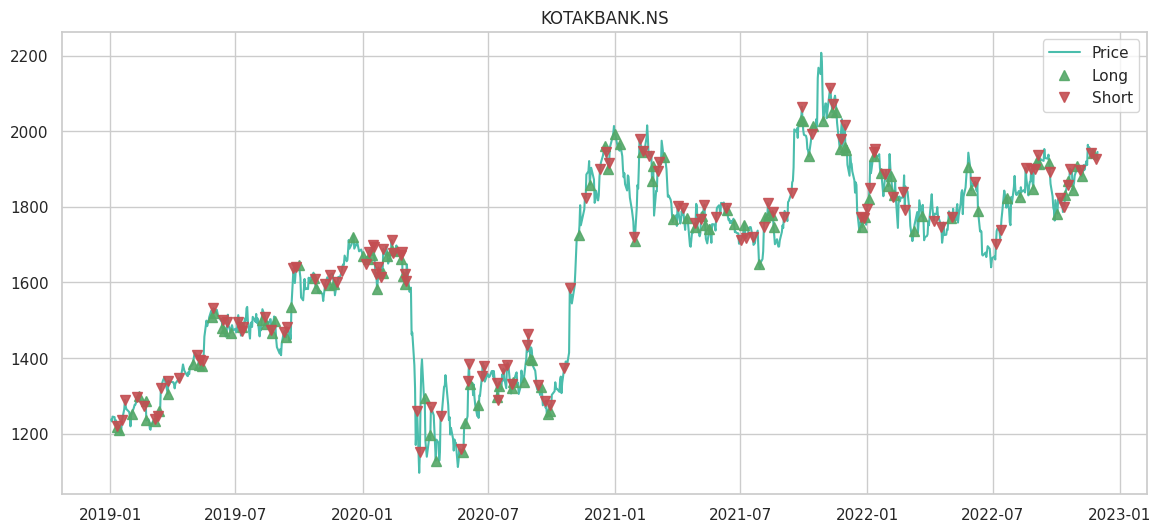

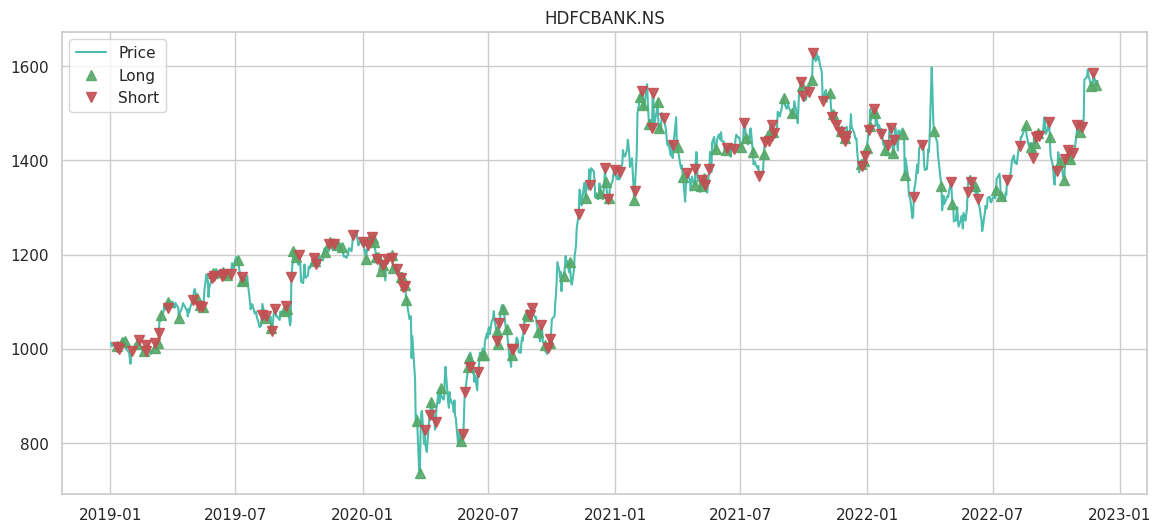

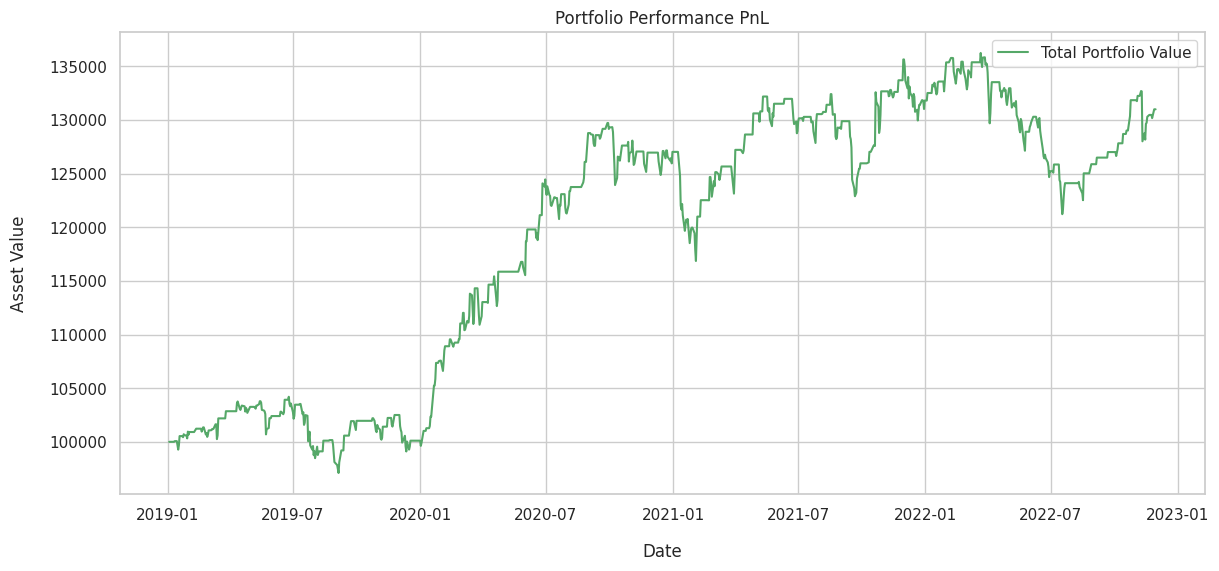

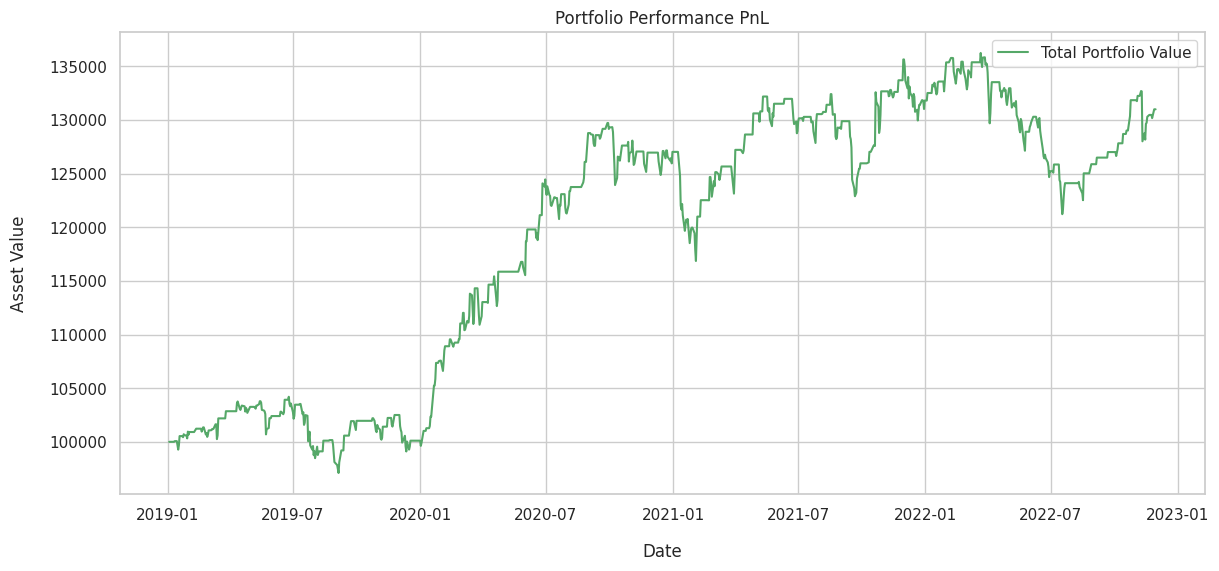

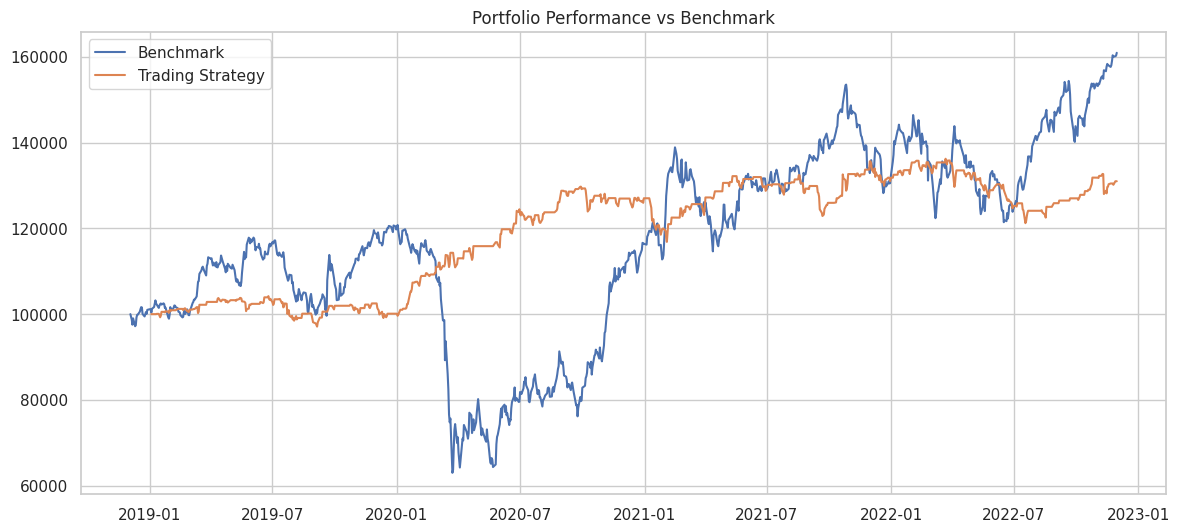

In [82]:
backtesting(dstart,dend)